# Varying non-specific binding rate

In [3]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from tapqir.models import Cosmos

## Load results

In [4]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [5]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("lamda"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        model = Cosmos()
        model.load(data_path, True, "cpu")
        model.load_parameters(param_path)
        mask = torch.from_numpy(model.data.labels["z"])
        samples = torch.masked_select(model.z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [11]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda").astype(float)
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr
lamda0.01,1.4,7.0,0.15,0.01,0.2,90.0,3000.0,150.0,3.758899
lamda0.05,1.4,7.0,0.15,0.05,0.2,90.0,3000.0,150.0,3.758899
lamda0.15,1.4,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758899
lamda0.5,1.4,7.0,0.15,0.50,0.2,90.0,3000.0,150.0,3.758899
lamda1,1.4,7.0,0.15,1.00,0.2,90.0,3000.0,150.0,3.758899


In [12]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="lamda")
fit_df["marginal"]

lamda0.01    True
lamda0.05    True
lamda0.15    True
lamda0.5     True
lamda1       True
Name: marginal, dtype: object

In [13]:
fit_df["classifier"]

lamda0.01    True
lamda0.05    True
lamda0.15    True
lamda0.5     True
lamda1       True
Name: classifier, dtype: object

In [17]:
fit_df["proximity_mean"]

lamda0.01    0.197120
lamda0.05    0.192259
lamda0.15    0.204713
lamda0.5     0.213073
lamda1       0.209150
Name: proximity_mean, dtype: float64

In [14]:
fit_df = fit_df.drop(columns=["marginal", "classifier"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,lamda
lamda0.01,3.740959,7.003331,7.003331,7.003331,0.146225,0.146225,0.146225,0.011004,0.011004,0.011004,...,1.000000,1.000000,2142.0,0.0,0.0,358.0,0.999849,0.999711,0.999895,0.01
lamda0.05,3.748954,6.995525,6.995525,6.995525,0.145051,0.145051,0.145051,0.051432,0.051432,0.051432,...,0.986034,0.994366,2140.0,2.0,5.0,353.0,0.999297,0.998651,0.999506,0.05
lamda0.15,3.767562,6.999659,6.999659,6.999659,0.147087,0.147087,0.147087,0.136816,0.136816,0.136816,...,0.977654,0.980392,2135.0,7.0,8.0,350.0,0.997925,0.995820,0.998526,0.15
lamda0.5,3.807789,7.030880,7.030880,7.030880,0.141167,0.141167,0.141167,0.492269,0.492269,0.492269,...,0.949721,0.965909,2130.0,12.0,18.0,340.0,0.992178,0.981530,0.995503,0.50
lamda1,3.837327,7.041692,7.041692,7.041692,0.134233,0.134233,0.134233,0.974017,0.974017,0.974017,...,0.910615,0.953216,2126.0,16.0,32.0,326.0,0.984635,0.957786,0.991965,1.00


## Supplementary Data 3

In [10]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data3/lamda.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")

## Figure 5

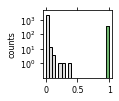

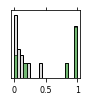

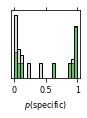

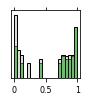

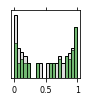

In [9]:
for name in fit_df.index:
    fig, ax = plt.subplots(figsize=(1.25, 1.25))
    ax.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k")
    ax.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k", alpha=0.6)
    ax.set_yscale("log")
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(1e-1, 5e3)
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="x", labelsize=8, top=True)
    
    if name == "lamda0.01":
        ax.set_ylabel("Counts", fontsize=8)
        ax.set_yticks([1, 10, 100, 1000])
        ax.tick_params(axis="y", labelsize=8)
    else:
        ax.set_yticks([])
        ax.tick_params(axis="y", labelsize=8)
    if name == "lamda0.15":
        ax.set_xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/lamda{name}.svg")
    plt.show()

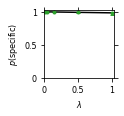

In [12]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.errorbar(truth_df["lamda"], fit_df["z_median"],
             yerr=abs(fit_df[["z_ll", "z_ul"]].values.T-fit_df["z_median"].values),
             fmt="o-", ms=3, color="k", mfc="C2", mec="C2", ecolor="C2", capsize=2)
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.set_ylabel(r"$p(\mathsf{specific})$", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/lamda-pspecific.svg")
plt.show()

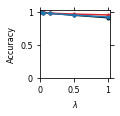

In [14]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.plot(truth_df["lamda"], fit_df["Recall"], "o-", color="k", ms=3, label="Recall")
ax.plot(truth_df["lamda"], fit_df["Precision"], "o-", color="C3", ms=3, label="Precision")
ax.plot(truth_df["lamda"], fit_df["MCC"], "o-", color="C0", ms=3, label="MCC")
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/lamda-accuracy.svg")
plt.show()